Временные ряды / Time Series
----

В этом блоке рассмотрим основные манипуляции с временными рядами. Для работы создадим фейковый датасет, отображающий динамику оценки удовлетворённости на основе пульс-опросов, которые проводятся раз в неделю по понедельникам.

Для удобства - будем считать, что каждый понедельник - рабочий день.

In [ ]:
'''
Импортируем библиотеки для работы в среду
'''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats
# from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import seaborn as sns
# import statsmodels.api as sm

Создание датафрейма
---

In [ ]:
'''
В этом блоке мы создаём датафрейм rawData в котором будет два значения: индекс (дата проведения пульс-опроса) и средний балл по компании

При этом добавим в датасет падение удовлетворённости в первом квартале 2014 года (начало валютного кризиса) и постепенное восстановление к обычным значениям в марте 2014
После 2015 года добавляем плавный линейный тренд на рост

Добавим сезонность:
--рост удовлетворённости летом (период отпусков) и перед новым годом (отпуск и годовая премия)
-- падение удовлетворённости в начале года (выход после каникул на работу - это грустно)
'''

### Это технический блок кода, направленный на создание фейковых данных. Комментарии минимальны

# Генерируем даты с интервалом по неделям (каждый понедельник) с 1 января 2010 по 31 декабря 2020
dates = pd.date_range(start='2010-01-01', end='2020-12-31', freq='W-MON')

# Базовые значения удовлетворённости (между 7 и 8)
baseSat = np.random.uniform(7, 8, size=len(dates))

# Добавляем сезонность, тренд и специфический паттерн 2014 года
for i, date in enumerate(dates):
    month = date.month
    year = date.year

    # Постепенное падение в первом квартале 2014 года
    if year == 2014:
        if month == 1:
            baseSat[i] = np.random.uniform(5, 6)  # Падение в январе
        elif month == 2:
            baseSat[i] += 0.5  # Восстановление в феврале
        elif month == 3:
            baseSat[i] += 1.0  # Дальнейшее восстановление в марте

    # Если год 2015 или позже, добавляем тренд на рост
    if year >= 2015:
        # Линейный тренд, который увеличивается со временем
        baseSat[i] += (year - 2014) * 0.1  # Тренд на увеличение

    # Летний сезон (июнь, июль, август) - увеличение
    if month in [6, 7, 8]:
        baseSat[i] += np.random.uniform(0.5, 2.1)  # Рост летом

    # Зимний сезон (последние две недели декабря) - увеличение
    elif month == 12 and date.day > 14:
        baseSat[i] += np.random.uniform(0.5, 2.1)  # Рост в конце декабря

    # Падение в январе и первые две недели февраля
    elif month == 1 or (month == 2 and date.day <= 14):
        baseSat[i] -= np.random.uniform(0.5, 2.1)  # Снижение в начале года

# Ограничим значения от 1 до 10
baseSat = np.clip(baseSat, 1, 10)

# Создадим DataFrame
rawData = pd.DataFrame({
    'Satisfaction': baseSat.round(2)
}, index=dates)


Исследование данных
---

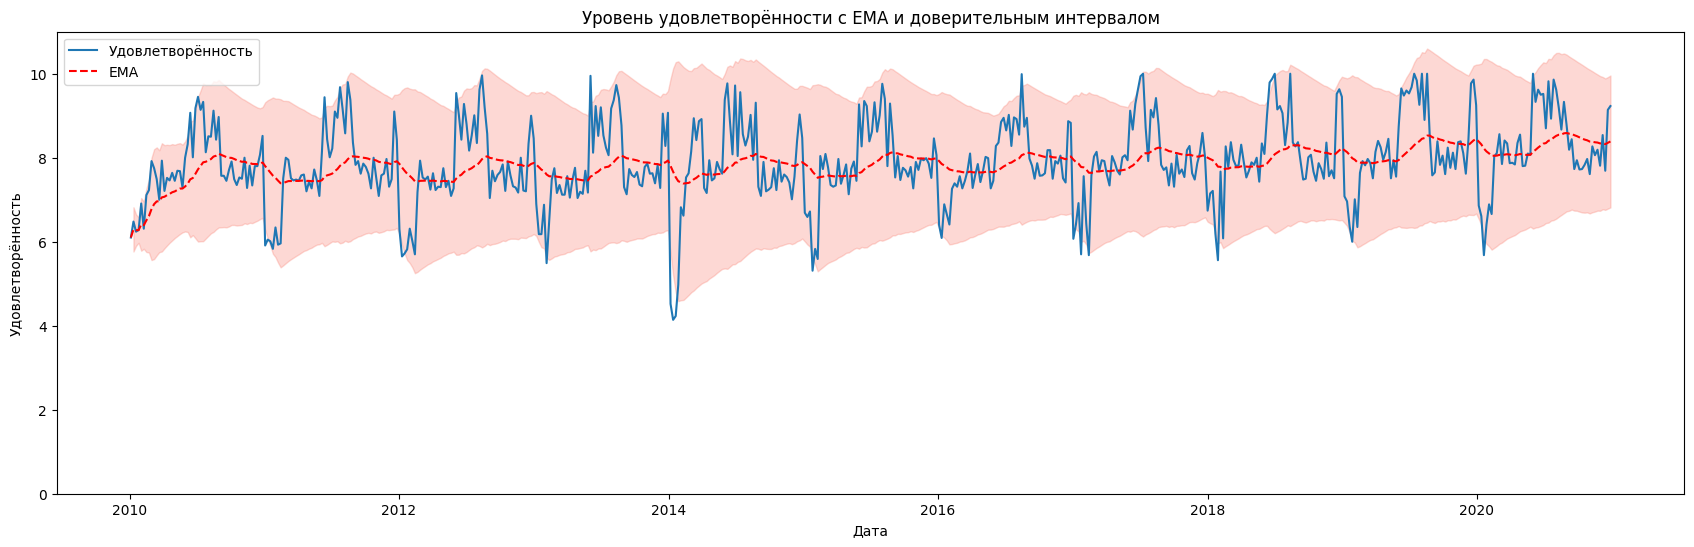

In [ ]:
'''
В этом блоке мы визуализируем наш временной ряд. Наша задача - посмотреть на тренды, сезонность и общее движение,
при этом снизив влияние случайных колебаний и шума в данных. Более того, логично, что в оценке трендов больший вес должны иметь "свежие" значения.
Эту задачу мы тоже решаем.
'''

### лучший способ избавиться от шума - использовать скользящее среднее (moving avarage), а лучший способ учесть большую важность последних периодов по сравнению с первыми - экспоненциальное MA (EMA)
### EMA уменьшает влияние случайных колебаний или "шума" в данных, помогая выявить основной тренд. Это особенно полезно, когда данные содержат значительные колебания или аномалии
### В отличие от простого скользящего среднего, EMA придает большее значение недавним данным, что позволяет быстрее реагировать на изменения в тенденции. Это помогает отслеживать последние изменения в данных
### Благодаря большему весу недавним данным, EMA позволяет быстрее заметить разворот тренда или новые тенденции, что может быть важно для принятия решений.
### Также мы строим доверительный интервал для EMA. Доверительный интервал показывает возможные границы, в которых может находиться истинное значение средней удовлетворенности.
### Он указывает на уровень неопределенности или разброса данных вокруг EMA. В нашем случае отвечаем на вопрос "в каких границах с 95% вероятность может находится EMA"
### Доверительный интервал помогает оценить стабильность или надежность данных.
### Если интервал широк, это может указывать на большую вариацию, что может означать более высокий риск или неопределенность. Узкий интервал, наоборот, указывает на большую стабильность
### Наличие доверительных интервалов позволяет заметить точки данных, которые выходят за пределы этих интервалов, что может указывать на аномалии или важные изменения в тенденции

expMean = rawData['Satisfaction'].ewm(span=52).mean() # Экспоненциальное скользящее среднее (EMA) с периодом сглаживания 52 недели
expStd = rawData['Satisfaction'].ewm(span=52).std() # Стандартное отклонение для экспоненциального скользящего среднего

cLow = expMean - 1.96 * expStd  # Нижняя граница доверительного интервала (1.96 - это "количество стандартных отклонений от среднего" в который попадает EMA с 95% вероятностью)
cUp = expMean + 1.96 * expStd  # Верхняя граница доверительного интервала

plt.figure(figsize=(21, 6)) # задаём размер полотна, на котором будем рисовать график

# Визуализируем основной временной ряд
plt.plot(rawData.index, ## ось X - временные метки
         rawData['Satisfaction'], ## оcь Y - значение удовлетворённости
         label='Удовлетворённость') ## текст легенды

# Добавляем на график значения EMA (мы сохранили их в expMean)
plt.plot(rawData.index,
         expMean,
         label='EMA',
         linestyle='--', ## тип линии
         color = 'red')  # цвет линии

# Добавляем на график доверительный интервал и заливаем облась между границами
plt.fill_between(rawData.index,
                 cLow, # нижняя граница
                 cUp, # верхняя граница
                 color='salmon', # лососевый цвет - лучший цвет :)
                 alpha=0.3)  # прозрачность заливки

plt.xlabel('Дата') # Легенда к оси X
plt.ylabel('Удовлетворённость') # Легенда к оси Y
plt.title('Уровень удовлетворённости с EMA и доверительным интервалом') # Заголовок
plt.legend() # Вывод легенды
plt.ylim(0,11) # Границы оси Y

plt.show() # Вывод всего графика

### ВЫВОД
### По этому графику сложно что-то понять :)
### Но виден рост и намёк на 3 сезонных паттерна
### EMA медленно и неспеша растёт, значит можно предположить тренд
### 2014 год - было сильное падение удовлетворённости в начале года, которое восстанавливалось до прежних значений дольше обычного. Это произошло ещё и в момент, когда активизируется сезонный паттерн
### Доверительный интервал очень широкий - опасно доверять таким данным. При этом тут скорее виновата сезонность, нежели кривые данные. Вначале думаем - потом делаем выводы

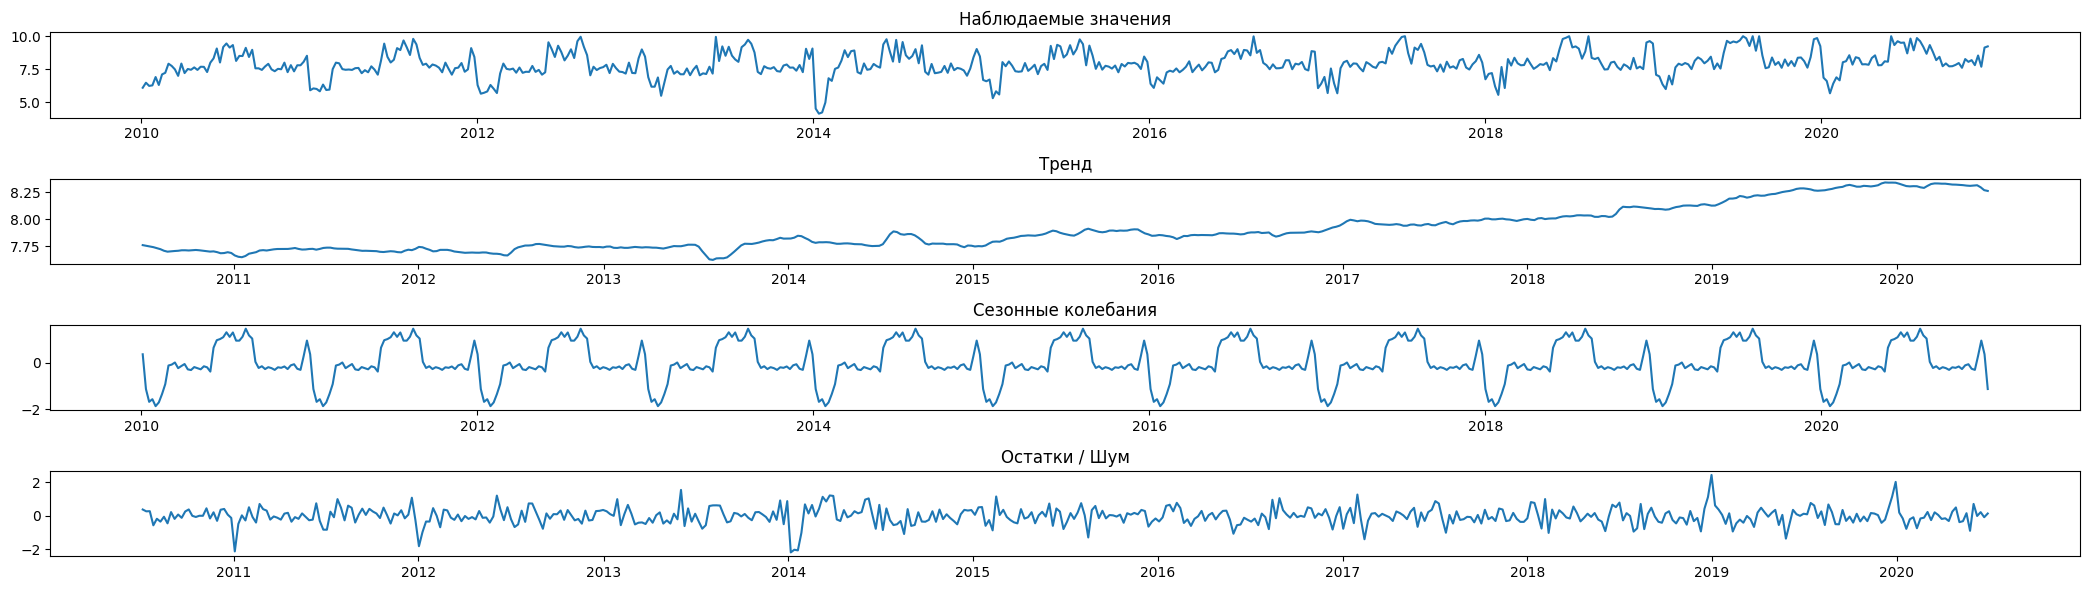

In [ ]:
'''
В этом блоке кода мы выполняем декомпозицию временного ряда, чтобы выделить его основные компоненты: тренд, сезонность и остаток (шум).
Мы используем аддитивную модель декомпозиции, которая предполагает, что временной ряд может быть представлен как сумма этих трех компонентов.
Период декомпозиции установлен на 52, что предполагает, что сезонные колебания могут быть связаны с недельными или годовыми циклами.

Мы делаем это, чтобы получить лучшее понимание структуры временного ряда.
Тренд показывает долгосрочные изменения, сезонность выявляет регулярные колебания или повторения, а остаток указывает на случайные колебания и шум.

Разбиение временного ряда на эти компоненты позволяет нам анализировать их отдельно,
что помогает выявить ключевые тенденции, обнаружить сезонные паттерны и оценить уровень шума в данных.
Эти знания могут быть полезны для прогнозирования, анализа изменений во времени или выявления аномалий.
'''

# Декомпозируем временной ряд (используем аддитивный метод)
## Здесь нужно выбрать между аддитивной и мультипликативной модели. Нам подходит аддитивная, поскольку она не предполагает, что сезонные колебания зависят от уровня тренда
## То есть если у нас есть сезоны "просадки" и "взлёта" по удовлетворённости, логично предположить, что их сила не зависит от тренда, они просто существуют
## Мультипликативная модель наоборот, предполагает, что сезонные колебания масштабируются в зависимости от уровня тренда. Например, если мы на максималках - то и сезонные колебания максимальны и наоборот

decomposition = seasonal_decompose(rawData,
                                   model='additive', ## тип модели
                                   period=52) ## выбираем период для декомпозиции в 52 недели (год). Недели - потому что у нас 1 замер в неделю. Выбор периодичности - ответственность аналитика

# Создаем новую фигуру с нужным размером
plt.figure(figsize=(21, 6))

# Располагаем четыре субграфика
plt.subplot(4, 1, 1)  # Первый субграфик
plt.plot(decomposition.observed) # Фактически наблюдаемые значения
plt.title('Наблюдаемые значения')

plt.subplot(4, 1, 2)  # Второй субграфик
plt.plot(decomposition.trend) # Тренд
plt.title('Тренд')

plt.subplot(4, 1, 3)  # Третий субграфик
plt.plot(decomposition.seasonal) # Сезонность
plt.title('Сезонные колебания')

plt.subplot(4, 1, 4)  # Четвертый субграфик
plt.plot(decomposition.resid) # Остаточный шум
plt.title('Остатки / Шум')

# Отображаем график
plt.tight_layout()  # Улучшает размещение графиков
plt.show()

### ВЫВОДЫ
### В данных присутствует 2-3 сезонных колебания. Рост под удовлетворённости под конец года и падение с первым рабочим днём в новом году - можно принять за один "сезон" (перед НГ - премии, после - похмелье)
### В период летних отпусков тоже наблюдается рост удовлетворённости (хотя на реальных данных обычно наборот, т.к. те, кто рад - на морях, а работающие обычно в печали)
### В 2014 году была более сильная и затяжная просадка (был валютный кризис)
### С 2015 начал оформляться тренд на рост удовлетворённости, под конец 2020 началось снижение. Но говорить о завершении тренда мы не можем - нет данных.

Проверка остатков (шума) на нормальность
---

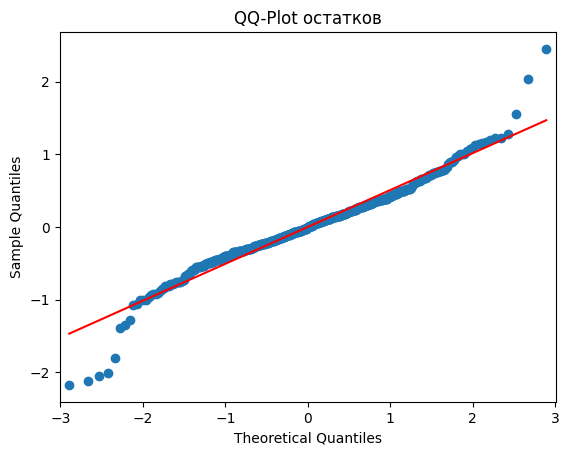

In [ ]:
'''
В этом блоке кода мы создаем QQ-plot (Quantile-Quantile plot) остатков временного ряда.
Этот график помогает оценить, насколько распределение остатков соответствует нормальному распределению.
Мы используем QQ-plot, чтобы визуально проверить, есть ли значительные отклонения от нормальности,
что может указывать на аномалии, выбросы или систематические ошибки в модели.

Зачем нам это нужно? QQ-plot позволяет визуализировать отклонения от нормального распределения,
показывая, как квантильные значения остатков сопоставляются с квантильными значениями нормального распределения.
Если точки на графике лежат близко к диагональной линии, это указывает на нормальность.
Если они сильно отклоняются, это может означать присутствие асимметрии, выбросов или аномалий.

Строя QQ-plot для остатков, мы можем понять, насколько они соответствуют предположению о нормальности.
Это важно, поскольку многие модели временных рядов, такие как ARIMA, предполагают нормальное распределение остатков.
Если обнаружены отклонения, это может быть признаком того, что модель нужно скорректировать или пересмотреть.

Если остатки временного ряда не распределены нормально, это может указывать на то, что данные содержат неизученные сезонные или трендовые паттерны.
Например, остатки могут показывать тенденцию к увеличению или уменьшению в зависимости от времени года или других факторов.
'''

# QQ-plot
sm.qqplot(decomposition.resid.dropna(), line='s')  # убираем пропуски, чтобы построить график
plt.title("QQ-Plot остатков")
plt.show()

### ВЫВОДЫ
### Похоже, остатки распределены нормально и мы ничего не упустили. Но есть "тяжёлые хвосты", это аномальные наблюдения, но погоды они нам не сделают

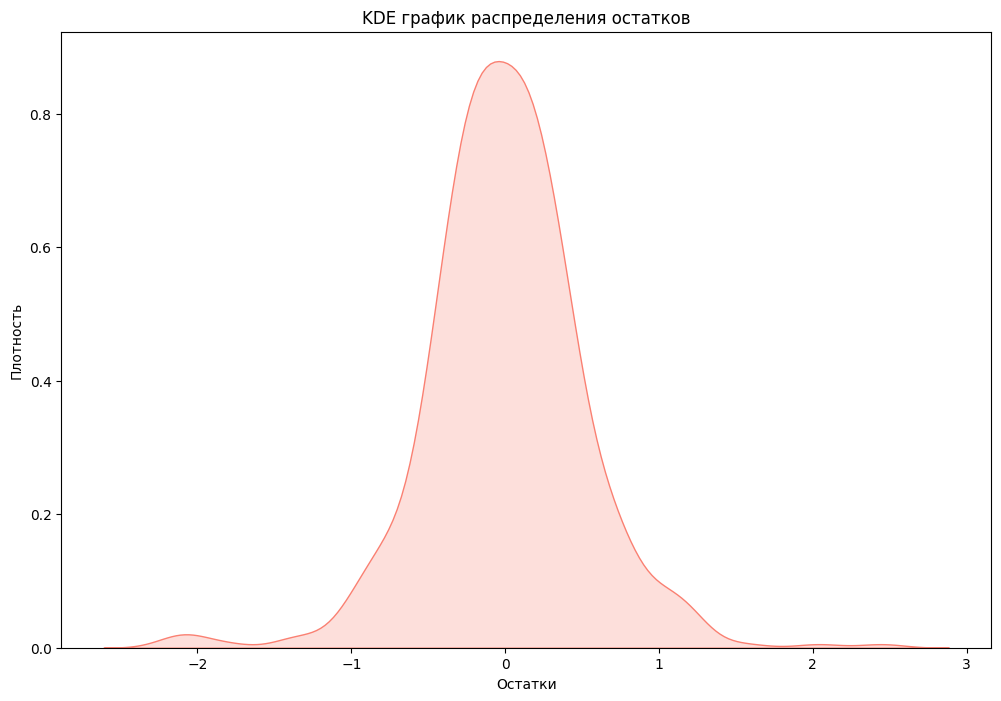

In [ ]:
'''
В этом блоке кода мы создаем график KDE (Kernel Density Estimate) для распределения остатков временного ряда.
KDE-график позволяет визуально оценить форму распределения данных, создавая сглаженную аппроксимацию плотности распределения.
Мы используем KDE для того, чтобы понять, насколько распределение остатков отличается от нормального распределения и выявить аномалии или выбросы.

Этот метод основан на сглаживании, что позволяет избежать резких переходов между данными и получить более плавное представление плотности распределения.
KDE может быть особенно полезен, когда нам нужно выявить многомодальность, асимметрию или другие особенности распределения.

Строя этот график, мы можем визуально оценить плотность распределения остатков и определить, есть ли аномалии, которые могут указывать на систематические ошибки или аномалии в данных.
Заполнение области под кривой (fill=True) подчеркивает, что интеграл под кривой равен 1, что соответствует стандартному распределению вероятностей.
Цветовая схема и размер графика (12x8) помогают улучшить визуальное восприятие.

Этот график полезен для определения общих свойств распределения остатков, что важно для проверки предположений о модели временного ряда, выявления возможных проблем и принятия решений о дальнейших шагах анализа.
'''

# KDE график для распределения остатков
plt.figure(figsize=(12, 8))
sns.kdeplot(decomposition.resid.dropna(), fill=True, color="salmon")  # заполненный KDE, чтобы область под кривой была = 1
plt.title("KDE график распределения остатков")
plt.xlabel("Остатки")
plt.ylabel("Плотность")
plt.show()  # отображаем

### ВЫВОД
### Абсолюнто аналогично QQ-plot, просто в более понятной форме. Очевидны тяжёлые хвосты, слева - вообще какой-то гигант (скорее всего его формирует 2014 год)

In [ ]:
'''
В этом блоке кода мы используем три различных статистических теста для проверки нормальности остатков, полученных из анализа временных рядов.
Нормальность остатков важна для определения корректности предположений, лежащих в основе многих статистических моделей, а также для оценки эффективности прогнозирования.

Мы используем следующие критерии согласия для проверки нормальности:
1. Тест Шапиро-Уилк: Это один из наиболее точных тестов для малых и средних выборок. Он определяет, насколько распределение данных близко к нормальному.
2. Тест Колмогорова-Смирнова: Этот тест сравнивает эмпирическое распределение данных с теоретическим нормальным распределением. Подходит для больших выборок.
3. Тест Андерсона-Дарлинга: Этот тест особенно чувствителен к отклонениям на концах распределения, что помогает выявлять выбросы (которые мы видели на графиках)

Мы используем эти тесты, чтобы убедиться, что остатки временного ряда соответствуют нормальному распределению, что важно для корректного использования статистических методов.
Результаты тестов дают статистические значения и p-значения, которые указывают, отклоняются ли остатки от нормального распределения.
'''


residuals = pd.Series(decomposition.resid.dropna()) # Сохраняем для удобства значения остатков в отдельную переменную.

shapiro_stat, shapiro_p = stats.shapiro(residuals) # Тест Шапиро-Уилка
ks_stat, ks_p = stats.kstest(residuals, 'norm') # Тест Колмогорова-Смирнова (предполагаем нормальное распределение)

ad_test = stats.anderson(residuals, dist='norm') # Тест Андерсона-Дарлинга
ad_stat = ad_test.statistic  # Извлекаюем значение статистики теста Андерсона-Дарлинга
ad_critical_values = ad_test.critical_values  # Критические значения на разных уровнях значимости

# Округлим значения до 3 знаков после запятой
shapiro_stat = round(shapiro_stat, 3)
shapiro_p = round(shapiro_p, 3)
ks_stat = round(ks_stat, 3)
ks_p = round(ks_p, 3)
ad_stat = round(ad_stat, 3)
ad_critical_values = [round(value, 3) for value in ad_critical_values]

# Возвращаем результаты тестов
print(shapiro_stat, shapiro_p)
print(ks_stat, ks_p)
print(ad_stat, ad_critical_values)

### Выводы
### Все три теста говорят о том, что отклонения от нормальности - значимые. Вполне вероятно, что есть неучтённые выбросы.
### Этот факт сужает круг доступных к применению в дальнейшем методов. Но в общем и целом можно иногда проигнорировать этот факт.

0.961 0.0
0.203 0.0
3.359 [0.572, 0.651, 0.781, 0.911, 1.084]


Проверка автокоррелций
----

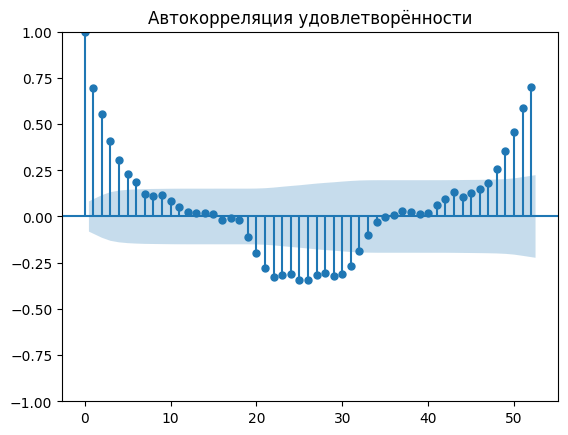

In [ ]:
'''
В этом блоке кода мы строим график автокорреляции (Autocorrelation Function, ACF) для временного ряда 'Satisfaction'.
Этот график позволяет оценить, насколько текущее значение ряда коррелирует с его предыдущими значениями на различных лагах.

Мы используем 52 лага, чтобы охватить годовой период, учитывая, что данные представлены по неделям.
Это поможет определить сезонные или долгосрочные тренды и связи в данных.

ACF-график помогает понять структуру временного ряда и выявить значимые корреляции.
График включает доверительный интервал, который указывает на статистически значимые корреляции.
Значимые автокорреляции могут свидетельствовать о наличии трендов, сезонных паттернов или других закономерностей в данных.

Вывод этого графика даст нам представление о наличии автокорреляции, которая может быть полезна при прогнозировании или моделировании.
'''

### Значения по оси Y варьируются от -1 до 1.
### Положительные значения автокорреляции означают, что есть прямая связь между текущим значением и значением с заданным лагом (т.е., высокое значение в прошлом соответствует высокому значению в будущем).
### Отрицательные значения указывают на обратную корреляцию (т.е., высокое значение в прошлом соответствует низкому значению в будущем).
### Если значения автокорреляции находятся в пределах доверительного интервала (залитая зона в нашем случае), это означает, что корреляция статистически незначима, и мы можем считать ее случайной.
### Если автокорреляция превышает доверительный интервал, это указывает на статистически значимую связь на данном лаге
### Первое значение коррелирует с самим собой - поэтому там 1 (лаг = 0)

plot_acf(rawData['Satisfaction'], lags=52)  # 52 - число лагов, чтобы охватить год. У нас понедельные данные, поэтому это логичный период
plt.title("Автокорреляция удовлетворённости")
plt.show()

### ВЫВОД
### Есть значимые корреляции и сезонность (см. выходы за синюю зону)

Проверка стационарности
----

In [ ]:
'''
В этом блоке кода мы применяем тест Дики-Фуллера (Augmented Dickey-Fuller, ADF) к временной серии, чтобы проверить её на стационарность.
Стационарность - это свойство временного ряда, при котором его статистические характеристики, такие как среднее и дисперсия, остаются постоянными во времени.

Мы тестируем на стационарность, потому что стационарные временные ряды имеют более простую структуру и обычно легче моделируются и прогнозируются.
Если временной ряд не является стационарным, это может указывать на наличие трендов, сезонности или других изменений со временем, которые могут усложнить анализ.

В нашем случае стационарность важна, потому что она позволяет оценить, насколько стабильны уровни удовлетворённости.
Если ряд нестационарен, это может указывать на долгосрочные тренды или сезонные колебания, которые нужно учитывать при прогнозировании или анализе.

Результаты теста ADF помогут нам понять, нужно ли применять методы стабилизации ряда, такие как дифференцирование или логарифмирование, перед использованием методов прогнозирования или анализа.
'''

### ADF Statistic: Значение ADF-статистики, которое используется для оценки стационарности. Отрицательные значения указывают на снижение автокорреляции в ряду с ростом лагов, что свидетельствует о возможной стационарности.
### p-value: Вероятность получить такие или более экстремальные значения статистики при условии, что нулевая гипотеза (нестационарность) верна.
### Малое p-значение указывает на то, что мы можем отвергнуть нулевую гипотезу и заключить, что ряд, вероятно, стационарен.

# Применяем тест на стационарность
adf_result = adfuller(rawData['Satisfaction'])
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

### ВЫВОД
### Ряд стационарен, стабилизация не требуется

ADF Statistic: -6.409049597098989
p-value: 1.910968679552417e-08
